# Data Incubator Data Science : Analysis

> I have extracted useful pieces of information from the Big Job Openings Data. Let's find out what kind of implications we can obtain in the IT job markets and its relations with Hardware prices and Politial approval ratings.

In [1]:
# Basic Libraries 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
# Read the trimmed parquet file
import pyarrow.parquet as pq

jobdf = pq.read_table('jobdf.parquet.snappy').to_pandas()

In [3]:
jobdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1267781 entries, 0 to 1267780
Data columns (total 6 columns):
title                 1267781 non-null object
category              1148290 non-null object
number_of_openings    1267781 non-null float32
posted_date           1267781 non-null datetime64[ns]
region                805956 non-null object
location_string       362028 non-null object
dtypes: datetime64[ns](1), float32(1), object(4)
memory usage: 62.9+ MB


## Oh.. so many duplicates.. 

In [4]:
jobdf = jobdf.drop_duplicates()

In [5]:
jobdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42582 entries, 0 to 1267780
Data columns (total 6 columns):
title                 42582 non-null object
category              38830 non-null object
number_of_openings    42582 non-null float32
posted_date           42582 non-null datetime64[ns]
region                28854 non-null object
location_string       13663 non-null object
dtypes: datetime64[ns](1), float32(1), object(4)
memory usage: 2.1+ MB


## Group `Jobs` by States 

In [6]:
jobdf[['title','region']].groupby('region').count().sort_values('title',ascending=False)[:10]

,title
region,
VA,4034
CA,2850
MD,2415
TX,1932
FL,1663
GA,1375
MA,1337
NY,1125
OR,949


### Let's do some statistics about `CA`, `NY`, and `TX`

#### About `TX`

In [7]:
jobtxdf = jobdf[jobdf.region == 'TX']

In [8]:
len(jobtxdf)

1932

In [9]:
jobtxdf[['title','category']].groupby('category').count().sort_values('title',ascending=False)[:20]

,title
category,
Sales,228
Service,139
"Installation, Maintenance, & Repair",109
Cyber Security,98
Service Technicians,95
Customer Service/Support,88
Service Advisors,66
Information Technology,54
Administrative/Clerical,52


In [10]:
jobtxIT = jobtxdf[jobtxdf.category == 'Information Technology']

In [11]:
jobtxIT.head(3)

,title,category,number_of_openings,posted_date,region,location_string
142612,Database Cyber Systems Security Assessor,Information Technology,1.0,2016-09-23,TX,None
142631,DATABASE CYBER SYSTEMS SECURITY ASSESSOR,Information Technology,1.0,2016-09-23,TX,None
200119,SOFTWARE DEVELOPER,Information Technology,1.0,2016-11-21,TX,None


In [12]:
jobtxIT.tail(3)

,title,category,number_of_openings,posted_date,region,location_string
1185318,"Test Engineer (Hardware, Software, Systems)",Information Technology,1.0,2017-08-21,TX,US-TX-San Antonio
1205296,Software Developer,Information Technology,1.0,2017-08-30,TX,US-TX-San Antonio
1223365,Automation Administrator (Software Developer),Information Technology,1.0,2017-09-13,TX,US-TX-San Antonio


> In general, hundred jobs are available even in Austin TX. I think the completeness of data is poor, I guess. Let's find out any useful inforation for `CA`

#### About `CA`

In [13]:
jobcadf = jobdf[jobdf.region == 'CA']
jobcadf[['title','category']].groupby('category').count().sort_values('title',ascending=False)[:20]

,title
category,
Engineering,400
Service,384
Sales,333
Information Technology,123
Other,104
Healthcare - Radiology/Imaging,74
Accounting/Finance,60
Field,57
Customer Service/Support,50


> Hum ... only 123 jobs during the year 2016 - 2017 in CA ?

#### About `NY`

In [14]:
jobnydf = jobdf[jobdf.region == 'NY']
jobnydf[['title','category']].groupby('category').count().sort_values('title',ascending=False)[:20]

,title
category,
Service,106
Sales,104
Commercial (Sales & Client Insights),55
Field,50
Engineering,34
Call Center,31
Operations,31
Healthcare - Radiology/Imaging,31
Information Technology,30


In [15]:
jobcaIT = jobcadf[jobcadf.category == 'Information Technology']
jobnyIT = jobnydf[jobnydf.category == 'Information Technology']

### Let's do some statistics on Montly Job Positings in `CA`, `NY`, and `TX`

#### Monly IT Jobs in  `CA`

In [16]:
monthlyJobsCA = pd.DataFrame(\
                           jobcaIT['posted_date']\
                           .groupby(by =[jobcaIT.posted_date.dt.year,jobcaIT.posted_date.dt.month]).count()\
                          )

In [17]:
monthlyJobsCA.columns = ['numPosts']

In [18]:
monthlyJobsCA.head(4)

numPosts
posted_date posted_date          
2016        7                   1
            8                   5
            9                   1
            10                  5

In [19]:
jobcaIT['number_of_openings'].groupby(by =[jobcaIT.posted_date.dt.year,jobcaIT.posted_date.dt.month]).sum()

posted_date  posted_date
2016         7               1.0
             8               5.0
             9               1.0
             10              5.0
             11              1.0
             12              1.0
2017         1               9.0
             2               3.0
             3              36.0
             4               7.0
             5               3.0
             6               9.0
             7              17.0
             8              18.0
             9               6.0
             10              1.0
Name: number_of_openings, dtype: float32

In [20]:
monthlyJobsCA['numJobs'] =\
jobcaIT['number_of_openings'].groupby(by =[jobcaIT.posted_date.dt.year,jobcaIT.posted_date.dt.month]).sum()

#### Monly IT Jobs in  `NY` and `TX`

In [21]:
monthlyJobsNY = pd.DataFrame(\
                           jobnyIT['posted_date']\
                           .groupby(by =[jobnyIT.posted_date.dt.year,jobnyIT.posted_date.dt.month]).count()\
                          )
monthlyJobsNY.columns = ['numPosts']

monthlyJobsTX = pd.DataFrame(\
                           jobtxIT['posted_date']\
                           .groupby(by =[jobtxIT.posted_date.dt.year,jobtxIT.posted_date.dt.month]).count()\
                          )
monthlyJobsTX.columns = ['numPosts']

In [22]:
monthlyJobsNY['numJobs'] =\
jobnyIT['number_of_openings'].groupby(by =[jobnyIT.posted_date.dt.year,jobnyIT.posted_date.dt.month]).sum()

monthlyJobsTX['numJobs'] =\
jobtxIT['number_of_openings'].groupby(by =[jobtxIT.posted_date.dt.year,jobtxIT.posted_date.dt.month]).sum()


> Make `datetime` from the multi index

In [23]:
monthlyJobsCA['yearmonth'] = pd.to_datetime({'year':[row[0] for row in monthlyJobsCA.index.values],
                'month':[row[1] for row in monthlyJobsCA.index.values],
                'day':np.full(len(monthlyJobsCA.index),1)
               }).values

In [24]:
monthlyJobsNY['yearmonth'] = pd.to_datetime({'year':[row[0] for row in monthlyJobsNY.index.values],
                'month':[row[1] for row in monthlyJobsNY.index.values],
                'day':np.full(len(monthlyJobsNY.index),1)
               }).values

In [25]:
monthlyJobsTX['yearmonth'] = pd.to_datetime({'year':[row[0] for row in monthlyJobsTX.index.values],
                'month':[row[1] for row in monthlyJobsTX.index.values],
                'day':np.full(len(monthlyJobsTX.index),1)
               }).values

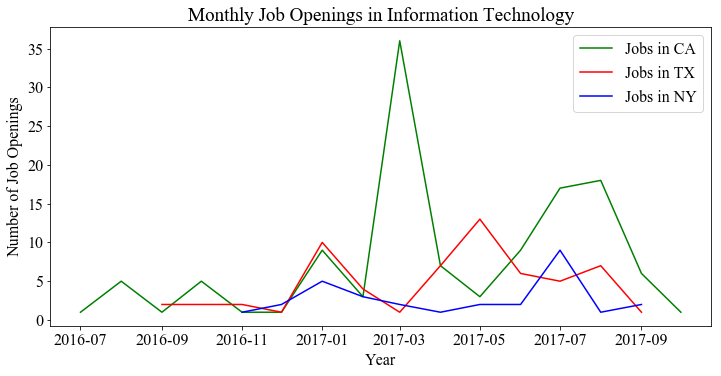

In [26]:
# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(10,5.2))

#plt.axis([0,lenmax,0,1.0])
plt.title("Monthly Job Openings in Information Technology")
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r'Number of Job Openings')
plt.xlabel(r'Year')
plt.plot(monthlyJobsCA.yearmonth,monthlyJobsCA.numJobs.values,color='g',label='Jobs in CA')
plt.plot(monthlyJobsTX.yearmonth,monthlyJobsTX.numJobs.values,color='r',label='Jobs in TX')
plt.plot(monthlyJobsNY.yearmonth,monthlyJobsNY.numJobs.values,color='b',label='Jobs in NY')

plt.legend(loc=1)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.savefig("car-accidents.eps")
fig.savefig("montly-it-jobs.png")
plt.show()

> **1. We have a spike in the CA job market in March 2017.** 

> **2. More jobs in summer season from May to September.** Due to the warm weather, TX starts its summer job openings eariler than the other States.

> 3. In Jaunary, there are more job openings in all States; maybe, due to the start of the new business year. 